In [1]:
import path
import libs.checker as checker
from control import *
from z3 import *
from scipy.signal import lti, step
import scipy.signal as sig

This example is borrowed and adapted from [1], which demonstrates a hybrid system design of a PD controller that drives a car position *p* to a desired position *r*, the design needs to satisfy a safety requirment: it never cross the desired position:
$$
\forall t . p(t) \le r
$$

The original design of the closed-loop function can be Laplace transformed into:
$$
H(s) = \frac{K_d s + K_p}{s^2+K_d s + K_p}
$$
where $K_p = 2$ and $K_d = 0.14$

We approximate it by a standard 2nd-order function:
$$
\hat{H}(s) = \frac{K_p}{s^2+K_d s + K_p}
$$

Using our numerical static checking, the design is found that doesn't met the safety requirement. In this case, our checker return *sat* and a counter example.

This example also shows that it is advisble to use a numerical checker instead of symbolic checker for a full hybrid design, as it avoids complex computation and possible fruitless searching by SMT solving.

[1] Jan-David Quesel, Stefan Mitsch, Sarah Loos, Nikos Aréchiga, and André Platzer. How to model and prove hybrid systems with KeYmaera: A tutorial on safety. STTT 18(1), pp. 67-91, 2016.

In [2]:
# Constants
Kp = 2
Kd = 0.14
r = 1

In [3]:
import numpy as np
tspan = np.arange(0, 100, 0.1).tolist()

# Original Transfer function
Hs_num = [Kd, Kp]
Hs_den = [1, Kd, Kp]
Hs = lti(Hs_num, Hs_den)
t1, s1 = step(Hs, T=tspan)

# Approximated transfer function
Hs_hat_num = [Kp]
Hs_hat_den = [1, Kd, Kp]
Hs_hat = lti(Hs_hat_num, Hs_hat_den)
t2, s2 = step(Hs_hat, T=tspan)

Next, let us static check the design *Hs_hat* against its desired safety requirement.

In [4]:
# Chars calculation
wn_square = Hs_hat_den[-1]
two_zeta_wn = Hs_hat_den[-2]

omega_n = math.sqrt(wn_square)
zeta = two_zeta_wn/(2*omega_n)

print(f'zeta = {zeta}, omega_n = {omega_n}')


zeta = 0.049497474683058325, omega_n = 1.4142135623730951


In [5]:
# Setup
c = checker.Checker(zeta,omega_n)

p = c.factory.y
t = c.factory.t
c.amp = 1           
r = c.amp
safety = p[t] <= r

c.auto_pog(safety)

In [6]:
# Numerical Static Checking in Z3 SMT solver
c.result()

static checking result =  sat
static checking model =  [y = Store(Store(Store(K(Real, 1.4279114819?),
                       38.4998640687?,
                       0.9),
                 38,
                 0.1),
           2.2241677454?,
           1.8558229638?),
 ft = 0,
 t2 = 38,
 input = 1,
 steady = 1,
 rise = 0.4998640687?,
 settle = 65.7881455141?,
 peak = 2.2241677454?,
 overshoot = 0.8558229638?,
 dc = 1]


Here, the solver return sat, which suggests a counter example is found. 

We want to first ensure that the approximation preserves the main dynamics of the original transfer function:

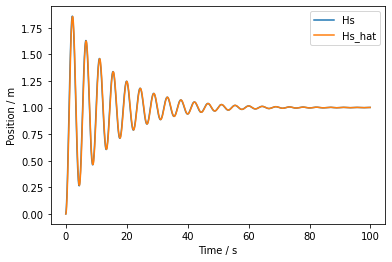

In [7]:
from matplotlib import pyplot as p

p.plot(t1, s1, label='Hs')
p.plot(t2,s2, label='Hs_hat')
p.xlabel('Time / s')
p.ylabel('Position / m')
p.legend()
p.show()

The plot showing that *Hs_hat* is a close approximation of *Hs*.

Now, by examing the counterexample: we find that the time-series *y* has a peak value of *1.8558229638?*, which is outside of the safe range and therefore violating the safety requirement.